In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import os

In [3]:
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_TRACING_V2=True
TAVILY_API_KEY="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"

In [4]:
def function_1(input_1):
    return input_1 + " First Function "

def function_2(input_2):
    return input_2 + " to Second Function"

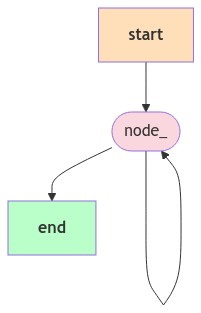

In [67]:
from langgraph.graph import Graph
workflow=Graph()

workflow.add_node("node1", function_1)
workflow.add_node("node2", function_2)

workflow.add_edge("node1", "node2")

workflow.set_entry_point("node1")
workflow.set_finish_point("node2")

app=workflow.compile()

# View
#display(Image(graph.get_graph().draw_mermaid_png()))
#display(Image(app.get_graph(xray=True).draw_mermaid_png()))
#Image(graph.get_graph().draw_mermaid_png(), width=1000, height=1000)
Image(app.get_graph().draw_mermaid_png(),height=1000)


In [6]:
app.invoke("i am sree and moving from")

'i am sree and moving from First Function  to Second Function'

#### if you want to see the results of the migration process you should use the following

In [20]:
input="sree and moving from"

for output in app.stream(input):
    for key,value in output.items():
        print(f"output from  node {key}: ")
        print("---------------")
        print(value)    
    print("-------------------")

output from  node node1: 
---------------
sree and moving from First Function 
-------------------
output from  node node2: 
---------------
sree and moving from First Function  to Second Function
-------------------


In [21]:
from langchain_openai import ChatOpenAI


llm=ChatOpenAI()
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000024C6E107550>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000024C6E2774D0>, openai_api_key=SecretStr('**********'), openai_proxy='')

In [28]:
llm.invoke("hi i am sree").content


'Hello Sree! How can I assist you today?'

In [44]:
def function_1(input_1):
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [India , Sports]. Don't include reasoning. Following is the user query: " + input_1
    response = llm.invoke(complete_query)
    return response.content

def function_2(input_2):
    TOPIC_UPPER = input_2.upper()
    response = f"Here is the topic in UPPER case: {TOPIC_UPPER}"
    return response

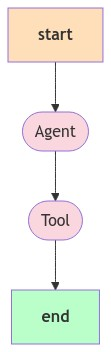

In [62]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("Tool", function_2)

workflow.add_edge('Agent', 'Tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("Tool")

app = workflow.compile()
# View
#display(Image(graph.get_graph().draw_mermaid_png()))
#display(Image(app.get_graph(xray=True).draw_mermaid_png()))
Image(app.get_graph().draw_mermaid_png())

In [47]:
query = "Tell me about India's Industrial Growth"
app.invoke(query)

'Here is the topic in UPPER case: INDIA'

In [48]:
for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n") 

Output from node 'Agent':
---
India

---

Output from node 'tool':
---
Here is the topic in UPPER case: INDIA

---



### RAG Pipeline integration

In [68]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
### Reading the txt files from source directory

loader = DirectoryLoader('./doc_repo', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
#doc_strings = [doc.page_content for doc in new_docs]
# Embed
vectorstore = Chroma.from_documents(documents=new_docs, 
                                    embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

In [69]:
query = "Tell me about Japan's Industrial Growth"
docs = retriever.get_relevant_documents(query)
print(docs)

c:\Users\WIN-10\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='Industrial revival hope for Japan', metadata={'source': 'doc_repo\\japan.txt'}), Document(page_content="Japan's last four year GDP:", metadata={'source': 'doc_repo\\japan.txt'}), Document(page_content="exports, normally the engine for Japan's economy in the face of weak domestic demand, had helped", metadata={'source': 'doc_repo\\japan.txt'}), Document(page_content="Japanese industry is growing faster than expected, boosting hopes that the country's retreat back", metadata={'source': 'doc_repo\\japan.txt'})]


### Integrating RAG pipeline with LangGraph and AgentState

In [80]:

# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [81]:
AgentState

{'messages': []}

In [94]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
# function_1 does teh topic calculation using llm , in this case whether it is Jpan or sports
def function_1(state):  
   
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + question
    response = llm.invoke(complete_query)
    state['messages'].append(response.content) # appending LLM call response to the AgentState
    return state
def function_2(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

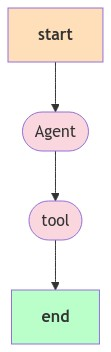

In [91]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

Image(app.get_graph().draw_mermaid_png())

In [100]:
inputs = {"messages": ["how sports evplved in america"]}
app.invoke(inputs)

'Based on the provided context, there is no information about how sports evolved in America. The context mainly talks about the guidance provided by Lester in sports.'

In [95]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
app.invoke(inputs)

'Rory McIlroy'

In [101]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'messages': ['how sports evplved in america', 'Sports', 'Sports']}

---

Output from node 'tool':
---
Based on the provided context, there is no information about how sports evolved in America. The context mainly discusses guidance in sports and specific athletes under guidance.

---

